In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from lightgbm import LGBMRegressor
import shap
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

In [40]:
# 1. Carga y preparación de datos
muestra = pd.read_csv('dataset.csv', low_memory=False)
users = pd.read_csv('users_age_gender.csv')
df = pd.merge(muestra, users[['household_ID', 'age_category', 'gender_label']], on='household_ID')

In [41]:
# Convertir objetivo a float
df['monthly_consumption_kwh'] = (
    df['monthly_consumption_kwh'].astype(str)
      .str.replace(',', '.', regex=False)
      .pipe(pd.to_numeric, errors='coerce')
)

In [42]:
df.dropna(subset=['monthly_consumption_kwh'], inplace=True)

In [43]:
# Sanitizar nombres de columnas
df.columns = (df.columns
    .str.replace(r'[^0-9A-Za-z_]+', '_', regex=True)
    .str.replace(r'__+', '_', regex=True)
    .str.strip('_')
)

In [44]:
# 4. Detectar y codificar todas las columnas 'object'
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in obj_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

**8.1 SHAP**

In [45]:
# 5. Definir X, y y metadatos
y = df['monthly_consumption_kwh']
X = df.drop(columns=['household_ID','monthly_consumption_kwh'])
age = df['age_category']
gender = df['gender_label']

In [46]:
# 6. Hold-out split (alineando índices y metadatos)
X_train, X_test, y_train, y_test, age_train, age_test, gender_train, gender_test = train_test_split(
    X, y, age, gender,
    test_size=0.2, random_state=42, shuffle=True
)

In [47]:
# 7. Entrenar modelo final
model = LGBMRegressor(
    learning_rate=0.05378, n_estimators=1410, max_depth=9,
    subsample=0.9988, colsample_bytree=0.7510,
    reg_alpha=0.00227, reg_lambda=2.1226, random_state=42
)
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 271
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 61
[LightGBM] [Info] Start training from score 144.450000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(colsample_bytree=0.751, learning_rate=0.05378, max_depth=9,
              n_estimators=1410, random_state=42, reg_alpha=0.00227,
              reg_lambda=2.1226, subsample=0.9988)

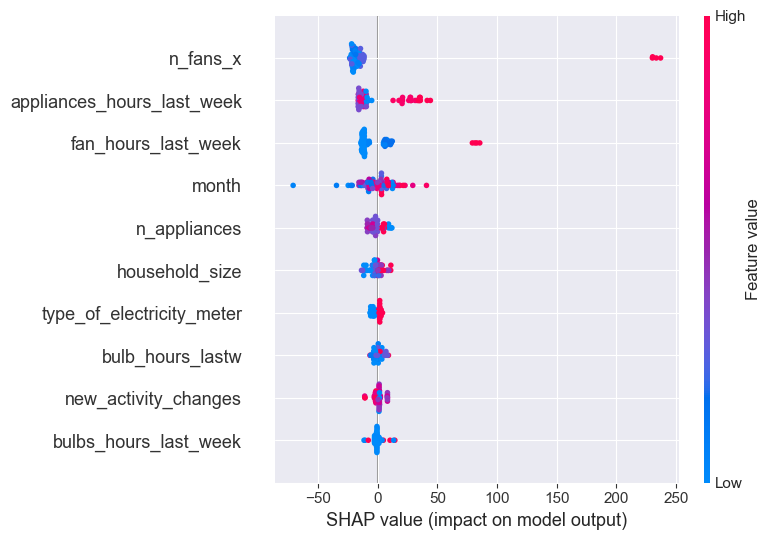

In [48]:
# SHAP
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Beeswarm top-10
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=10)

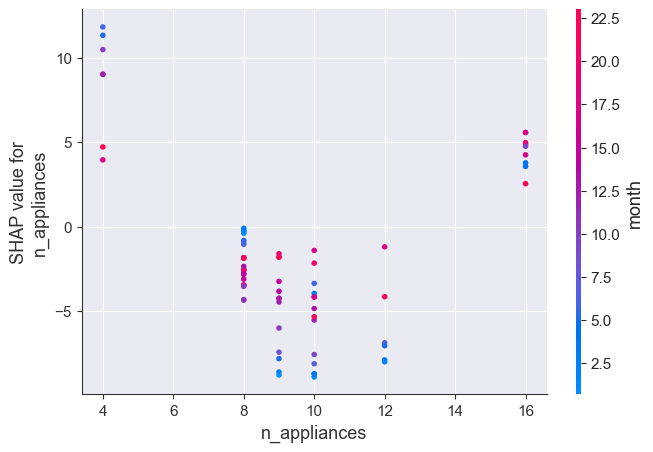

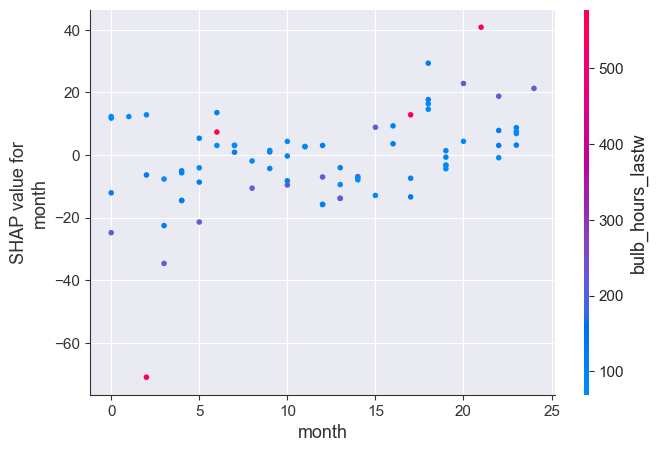

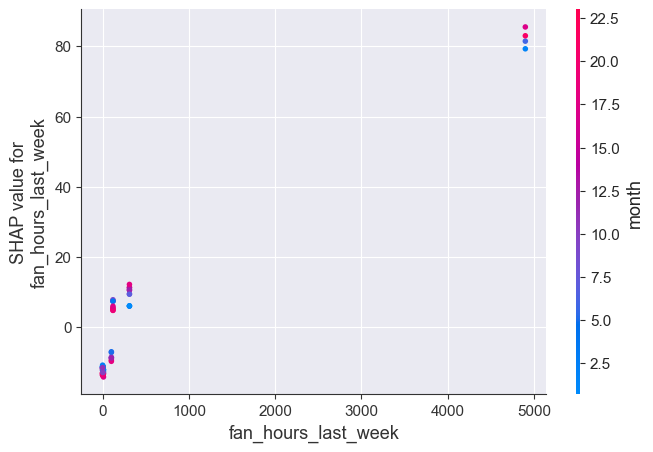

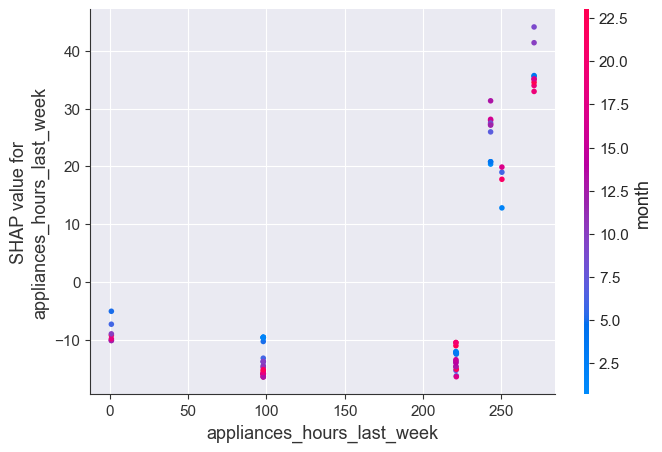

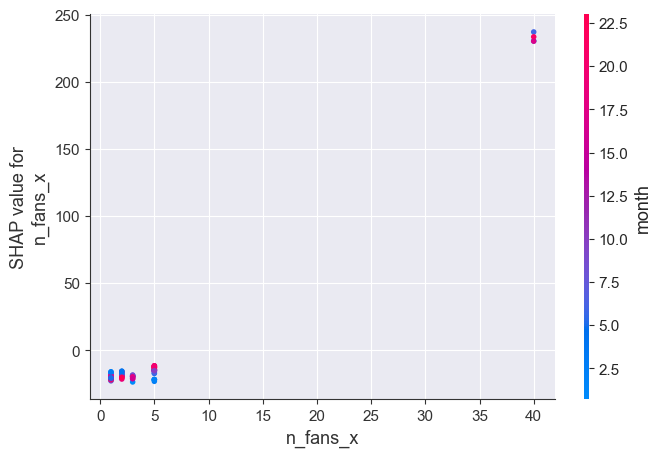

In [49]:
# Dependence plots para las 5 más importantes
top_feats = X_test.columns[np.argsort(np.abs(shap_values).mean(0))[-5:]]
for feat in top_feats:
    shap.dependence_plot(feat, shap_values, X_test)

**LIME para consumo bajo/medio/alto**

In [55]:
# Eliminar las columnas que quedan 100% vacías (todo NaN)
all_nan = df.columns[df.isna().all()].tolist()
df = df.drop(columns=all_nan)

# Definir X, y y metadatos
y = df['monthly_consumption_kwh']
X = df.drop(columns=['household_ID','monthly_consumption_kwh'])
age = df['age_category']
gender = df['gender_label']

# Hold-out split (alineando índices y metadatos)
X_train, X_test, y_train, y_test, age_train, age_test, gender_train, gender_test = train_test_split(
    X, y, age, gender,
    test_size=0.2, random_state=42, shuffle=True
)

# Imputador: median para numéricos, moda para categóricos
# Como todo es numérico (enteros codificados y floats), usamos 'median'.
imputer = SimpleImputer(strategy='median')

# Ajustar en train y transformar train/test
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# 9. Entrenar modelo final
model = LGBMRegressor(
    learning_rate=0.05378, n_estimators=1410, max_depth=9,
    subsample=0.9988, colsample_bytree=0.7510,
    reg_alpha=0.00227, reg_lambda=2.1226, random_state=42
)
model.fit(X_train_imp, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 300, number of used features: 60
[LightGBM] [Info] Start training from score 144.450000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LGBMRegressor(colsample_bytree=0.751, learning_rate=0.05378, max_depth=9,
              n_estimators=1410, random_state=42, reg_alpha=0.00227,
              reg_lambda=2.1226, subsample=0.9988)

In [57]:
cons_vals = y_test.values
idxs = [np.argmin(cons_vals), np.argsort(cons_vals)[len(cons_vals)//2], np.argmax(cons_vals)]
explainer_lime = LimeTabularExplainer(
    X_train_imp.values, feature_names=X_train_imp.columns.tolist(), mode='regression'
)
for idx in idxs:
    # Obtener la fila por posición con iloc, o directamente de .values
    row = X_test_imp.iloc[idx].values  
    exp = explainer_lime.explain_instance(
        row,
        model.predict,
        num_features=5
    )
    print(f"\nLIME explicación para posición {idx} (consumo={cons_vals[idx]:.1f} kWh):")
    for feature, weight in exp.as_list():
        print(f"  {feature}: {weight:.3f}")


LIME explicación para posición 40 (consumo=44.0 kWh):
  n_fans_x <= 1.00: -27.141
  fan_hours_last_week <= 3.33: -18.312
  98.00 < appliances_hours_last_week <= 221.00: -14.734
  month <= 6.00: -12.221
  3_We_iron_the_clothes_daily <= 0.00: -7.368

LIME explicación para posición 2 (consumo=102.0 kWh):
  2.00 < n_fans_x <= 5.00: -32.788
  fan_hours_last_week <= 3.33: -15.891
  month <= 6.00: -15.385
  appliances_hours_last_week <= 98.00: -14.882
  household_size <= 6.00: -11.349

LIME explicación para posición 71 (consumo=543.0 kWh):
  n_fans_x > 5.00: 268.295
  fan_hours_last_week > 120.00: 36.959
  appliances_hours_last_week > 243.15: 33.543
  n_bulbs_x > 10.00: 23.302
  month > 18.00: 17.250


In [58]:
# 8.2 Importancia global (mean | SHAP |)
shap_imp = pd.DataFrame({
    'feature': X_test_imp.columns,
    'mean_abs_shap': np.abs(shap_values).mean(0)
}).sort_values('mean_abs_shap', ascending=False).head(5)
print("\nTop 5 global SHAP importance:")
print(shap_imp.to_string(index=False))


Top 5 global SHAP importance:
                   feature  mean_abs_shap
                  n_fans_x      29.825677
appliances_hours_last_week      16.265223
       fan_hours_last_week      10.732518
                     month      10.477486
            household_size       5.553045


In [59]:
# 8.3 Sesgos: MAE por género y edad
y_pred = model.predict(X_test_imp)
residuals = np.abs(y_test.values - y_pred)
bias_df = pd.DataFrame({
    'residual': residuals,
    'gender':   gender_test.values,
    'age_cat':  age_test.values
})
print("\nMAE por género:")
print(bias_df.groupby('gender')['residual'].mean())
print("\nMAE por categoría de edad:")
print(bias_df.groupby('age_cat')['residual'].mean())
print("\nΔMAE género:", np.ptp(bias_df.groupby('gender')['residual'].mean()))
print("ΔMAE edad:",   np.ptp(bias_df.groupby('age_cat')['residual'].mean()))


MAE por género:
gender
0    7.245695
1    8.776242
Name: residual, dtype: float64

MAE por categoría de edad:
age_cat
0    10.787415
1     5.077202
2     8.427226
3     9.031512
4     6.778187
Name: residual, dtype: float64

ΔMAE género: 1.530546867218991
ΔMAE edad: 5.710212791808275
